<h1 align="center">Women in Government: Automated Collection of MPs' Gender Data Using Images</h1>
<h2 align="center"> by Alina Cherkas</h2>

## Abstract

This notebook is used to demonstrate how data science tools and techniques can be used to facilitate data collection on women's representation in politics. In so doing, I first collect aggregated data from the [New Parline](https://data.ipu.org/home), the Inter-Parliamentary Union's Open Data Platform. Secondly, I randomly sample 5 chambers and acquire a name, parliamentary webpage link and image of every MP in my sample. Using machine learning capacities of [Cognitive Services](https://azure.microsoft.com/en-us/services/cognitive-services/) provided by Microsoft Azure, I predict gender and age of MPs using their photos. Finally, I aggregate the data and compare it to the IPU's official information. Despite the fact that some MPs' images were missing, the results are strikingly similar. Based on my sample, the mean absolute error of women's share was 0.308% with no estimate deviating from the official numbers more than 1%.
***
## Résumé
Ce notebook est utilisé pour démontrer comment on peut employer les instruments et techniques de science des données pour faciliter la collection de données sur la représentation des femmes en politique. Ce faisant, premièrement, je recueille des données agrégées de [New Parline](https://data.ipu.org/home), la plateforme de données ouvertes de l'Union Interparlementaire. Deuxièmement, je prends un échantillon au hasard des 5 chambres et puis j’obtiens un nom, un lien de page Web parlementaire et une image de chaque député de mon échantillon. En utilisant les capacités d'apprentissage automatique des [Cognitive Services](https://azure.microsoft.com/en-us/services/cognitive-services/) fournies par Microsoft Azure, je prédis le sexe et l'âge des députés à l'aide de leurs photos. Enfin, j'agrège les données et les compare aux informations officielles de l'UIP. Même si les images de certains députés manquaient, les résultats sont étonnamment similaires. Basé sur mon échantillon, l'erreur absolue moyenne de la proportion des femmes était de 0,308%, sans aucune estimation déviant des chiffres officiels plus de 1%.

## Table of Contents
[**I. Data Acquisition: New Parline**](#I.-Data-Acquisition:-New-Parline)
<br>


[**II. Data Acquisition: Sampled Parliaments**](#II.-Data-Acquisition:-Sampled-Parliaments)
1. [Georgia: Sakartvelos Parlamenti](#Georgia:-Sakartvelos-Parlamenti)
2. [Trinidad and Tobago: House of Representatives](#Trinidad-and-Tobago:-House-of-Representatives)
3. [Republic of Korea: Kuk Hoe](#Republic-of-Korea:-Kuk-Hoe)
4. [Vanuatu: Parliament](#Vanuatu:-Parliament)
5. [Mexico: Cámara de Diputados](#Mexico:-Cámara-de-Diputados)

[**III. Data Analysis: Predicting MPs' Gender**](#III.-Data-Analysis:-Predicting-MPs'-Gender)

[**Concluding Remarks**](#Concluding-Remarks)

[**Examples of Images and Predictions**](#Examples-of-Images-and-Predictions)

<div class="alert alert-block alert-warning">

<b>Note:</b> The primary goal of the Python code below is to illustrate the plausibility and efficency of autotomated data collection and <b>not</b> to provide a ready-to-use solution. The code heavily relies on helper functions from SomeTools, a local package, and will not run without it.
</div>

### Libraries

In [1]:
# Standard library imports
import requests
import urllib

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from bs4 import BeautifulSoup
from tqdm import tqdm

# Local packages
import SomeTools as st
print('Requested libraries have been loaded!')

Requested libraries have been loaded!


## I. Data Acquisition: New Parline
I start by collecting the data from the IPU's website:

In [2]:
link = 'https://data.ipu.org/compare?field=country%3A%3Afield_structure_of_parliament#map'
print(link)

https://data.ipu.org/compare?field=country%3A%3Afield_structure_of_parliament#map


In [3]:
df_alpha = st.get_new_parline(link)
print(f'Shape:{df_alpha.shape}')
display(df_alpha.head())

0it [00:00, ?it/s]

Collected 274 links to chambers. Example: https://data.ipu.org/content/afghanistan?chamber_id=13574


153it [00:30,  5.64it/s]

The parliament of Mauritania was dissolved: https://data.ipu.org/content/mauritania?chamber_id=67284


231it [00:45,  3.83it/s]

The parliament of Sudan was dissolved: https://data.ipu.org/content/sudan?chamber_id=13530
The parliament of Sudan was dissolved: https://data.ipu.org/content/sudan?chamber_id=13529


274it [00:54,  6.86it/s]


Shape:(271, 28)


,Country,Political system,Structure of parliament,IPU membership,Parliament name,Chamber name,Structure & Status of parliament,Parliamentary term (years),Statutory number of members,Principal mode of designation of members,...,Inhabitants per parliamentarian,Parliamentary website,Men,Rules of procedure/Standing Orders,List of members,Constitution,Indirectly elected members,Appointed members,Notes,Frequency of renewal (years)
0,Antigua and Barbuda,Parliamentary system,Bicameral,No,Parliament,House of Representatives,Lower chamber,5,18,Directly elected,...,"2,857",https://ab.gov.ag/detail_page.php?page=8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Andorra,Parliamentary system,Unicameral,Yes,Consell general (General Council),Consell general (General Council),NaN,4,28,Directly elected,...,"2,786",http://www.consellgeneral.ad,15,http://www.consellgeneral.ad/fitxers/documents...,http://www.consellgeneral.ad/ca/composicio-act...,http://www.consellgeneral.ad/fitxers/documents...,NaN,NaN,NaN,NaN
2,Angola,Presidential-Parliamentary,Unicameral,Yes,Assembleia nacional (National Assembly),Assembleia nacional (National Assembly),NaN,5,220,Directly elected,...,"126,632",http://www.parlamento.ao,154,http://www.parlamento.ao/web/guest/actividade-...,NaN,https://wipolex.wipo.int/en/details.jsp?id=5622,NaN,NaN,NaN,NaN
3,Afghanistan,Presidential system,Bicameral,Yes,Jirga (National Assembly),Meshrano Jirga (House of Elders),Upper chamber,NaN,102,Indirectly elected,...,"95,841",http://www.parliament.af/,NaN,http://www.meshran.website/pve/showdoc.aspx?Id=69,NaN,http://www.meshran.website/pve/showdoc.aspx?Id...,68,34,NaN,NaN
4,Albania,Parliamentary system,Unicameral,Yes,Albanian Parliament,Kuvendi (Parliament),NaN,4,140,Directly elected,...,"20,879",http://www.parlament.al/,86,NaN,http://www.parlament.al/web/Statistics_1105_2.php,https://wipolex.wipo.int/en/text.jsp?file_id=2...,NaN,NaN,NaN,NaN


The dataframe above contains information on 271 chambers. I scraped only some of the sections available on the website.

In [4]:
#df_alpha.to_feather('Out1_Chambers.feather')
print('Saved!')

Saved!


In [5]:
df_alpha['IPU membership'].value_counts()

Yes    248
No      23
Name: IPU membership, dtype: int64

I will leave out the parliaments that are not members of the IPU and tidy up the data a bit:

In [6]:
df_alpha = st.clean_new_parline(df_alpha, only_IPU_members = True, only_with_website = True)
display(df_alpha.sample(3))

Initial shape:(271, 28)
Only IPU members, shape:(248, 28)
Only with website, shape:(235, 28)


,Country,Political system,Structure of parliament,Parliament name,Chamber name,Structure & Status of parliament,Parliamentary term (years),Statutory number of members,Note on the statutory number of members,Principal mode of designation of members,Directly elected members,Indirectly elected members,Appointed members,Other members,Current number of members,Men,Women,Percentage of women,Parliamentary website,List of members
156,Mauritius,Parliamentary system,Unicameral,National Assembly - Assemblée nationale,National Assembly,NaN,5.0,70.0,Appointed members: the Electoral Supervisory C...,Directly elected,62.0,NaN,8.0,NaN,70.0,56.0,14.0,20.00,http://mauritiusassembly.govmu.org/English/Pag...,http://mauritiusassembly.govmu.org/English/hme...
20,Bahrain,Monarchy,Bicameral,Al-Majlis Al-Watani (National Assembly),Majlis Al-Shura (Shura Council),Upper chamber,4.0,40.0,Appointed by the King.,Appointed,NaN,NaN,40.0,NaN,40.0,NaN,9.0,22.50,http://www.shura.bh/En/pages/default.aspx,http://www.shura.bh/en/Council/MPs/Pages/defau...
46,Cambodia,Parliamentary system,Bicameral,Parliament (Parliament),Senate,Upper chamber,6.0,62.0,Indirectly elected members: 58 members are ele...,Indirectly elected,NaN,60.0,2.0,NaN,62.0,NaN,11.0,17.74,https://senate.gov.kh/kh/index.php/kh/index.ph...,http://www.cambodia.org/facts/?government=Sena...


Below are the summary statistics with regard to parliamentary terms as well as size and composition of chambers:

In [7]:
df_alpha.describe().round(2)

,Parliamentary term (years),Statutory number of members,Directly elected members,Indirectly elected members,Appointed members,Other members,Current number of members,Men,Women,Percentage of women
count,226.00,235.00,190.00,41.00,44.00,39.00,235.00,128.00,230.00,230.00
mean,4.69,183.39,181.57,142.32,52.43,14.38,182.54,163.55,45.85,23.95
std,0.76,239.20,152.26,462.98,108.78,26.03,238.86,221.53,68.31,12.21
min,2.00,11.00,13.00,6.00,2.00,1.00,11.00,12.00,0.00,0.00
25%,4.00,65.00,71.25,26.00,8.00,1.50,64.00,56.75,12.00,15.38
50%,5.00,122.00,133.50,54.00,15.50,4.00,120.00,105.50,25.50,21.88
75%,5.00,227.50,249.50,96.00,49.50,16.00,227.50,213.00,51.75,31.36
max,8.00,3000.00,650.00,3000.00,676.00,115.00,2975.00,2233.00,742.00,61.25


Let's take a random sample of 5 chambers to work with:

In [8]:
df_lambda  = df_alpha.sample(5).reset_index(drop = True)
print(f'Shape:{df_lambda.shape}. Countries:', df_lambda['Country'].values)
df_lambda['Parliamentary website']

Shape:(5, 20). Countries: ['Georgia' 'Trinidad and Tobago' 'Republic of Korea' 'Vanuatu' 'Mexico']


0    http://www.parliament.ge/en/
1    http://www.ttparliament.org/
2       http://www.assembly.go.kr
3      https://parliament.gov.vu/
4    http://www.diputados.gob.mx/
Name: Parliamentary website, dtype: object

In [9]:
#df_lambda.to_feather('Out2_Chambers_Sample.feather')
print('Saved!')

Saved!


## II. Data Acquisition: Sampled Parliaments

In this section, I collect the data on MPs from webpages of national parliaments.

In [2]:
# Reading in the data
df_alpha = pd.read_feather('Out2_Chambers_Sample.feather')
print(f'Shape:{df_alpha.shape}')
display(df_alpha)

Shape:(5, 20)


,Country,Political system,Structure of parliament,Parliament name,Chamber name,Structure & Status of parliament,Parliamentary term (years),Statutory number of members,Note on the statutory number of members,Principal mode of designation of members,Directly elected members,Indirectly elected members,Appointed members,Other members,Current number of members,Men,Women,Percentage of women,Parliamentary website,List of members
0,Georgia,Parliamentary system,Unicameral,Sakartvelos Parlamenti (Parliament),Sakartvelos Parlamenti (Parliament),None,4.0,150.0,None,Directly elected,150.0,NaN,NaN,NaN,149.0,127.0,22.0,14.77,http://www.parliament.ge/en/,http://www.parliament.ge/en/parlamentarebi/dep...
1,Trinidad and Tobago,Parliamentary system,Bicameral,Parliament,House of Representatives,Lower chamber,5.0,42.0,The Speaker may be designated from outside par...,Directly elected,41.0,NaN,NaN,1.0,42.0,29.0,13.0,30.95,http://www.ttparliament.org/,http://www.ttparliament.org/members.php?mid=54
2,Republic of Korea,Presidential system,Unicameral,Kuk Hoe (National Assembly),Kuk Hoe (National Assembly),None,4.0,300.0,None,Directly elected,300.0,NaN,NaN,NaN,300.0,250.0,50.0,16.67,http://www.assembly.go.kr,http://korea.assembly.go.kr/mem/mem_01.jsp
3,Vanuatu,Parliamentary system,Unicameral,Parliament,Parliament,None,4.0,52.0,None,Directly elected,52.0,NaN,NaN,NaN,52.0,NaN,0.0,0.00,https://parliament.gov.vu/,https://parliament.gov.vu/index.php/memebers/m...
4,Mexico,Presidential system,Bicameral,Congreso de la Unión (Congress of the Union),Cámara de Diputados (Chamber of Deputies),Lower chamber,3.0,500.0,None,Directly elected,500.0,NaN,NaN,NaN,500.0,259.0,241.0,48.20,http://www.diputados.gob.mx/,http://sitl.diputados.gob.mx/LXII_leg/listado_...


In [3]:
print(df_alpha['Parliamentary website'])

0    http://www.parliament.ge/en/
1    http://www.ttparliament.org/
2       http://www.assembly.go.kr
3      https://parliament.gov.vu/
4    http://www.diputados.gob.mx/
Name: Parliamentary website, dtype: object


I manually explore each parliaments website to find a page that lists or points to the list of MPs. While quite some data can be scraped from most parliamentary websites, I am interested in collecting only links to MPs' pages, their names and photos.

### Georgia: Sakartvelos Parlamenti

In [4]:
link = 'http://www.parliament.ge/en/parlamentarebi/deputatebis-sia'
print(link)

http://www.parliament.ge/en/parlamentarebi/deputatebis-sia


In [5]:
df_alpha = st.get_mps(link, country = 'Georgia', chamber = 'Sakartvelos Parlamenti')
print(f'Shape:{df_alpha.shape}')
display(df_alpha.sample(2))

Shape:(148, 6)


,Country,Chamber,Name,Link,Photo_Link,Photo_Path
146,Georgia,Sakartvelos Parlamenti,George Volski,http://www.parliament.ge/en/mp/2456,http://www.parliament.ge/cache/photos/2456.jpg,./MPs Images/Georgia/Sakartvelos Parlamenti/GE...
16,Georgia,Sakartvelos Parlamenti,Givi Chichinadze,http://www.parliament.ge/en/mp/6534,http://www.parliament.ge/cache/photos/6534.jpg,./MPs Images/Georgia/Sakartvelos Parlamenti/GE...


### Trinidad and Tobago: House of Representatives

In [6]:
link = 'http://www.ttparliament.org/members.php?mid=54'
print(link)

http://www.ttparliament.org/members.php?mid=54


In [7]:
df_lambda = st.get_mps(link, country = 'Trinidad and Tobago', chamber = 'House of Representatives')
print(f'Shape:{df_lambda.shape}')
display(df_lambda.sample(2))

42it [00:35,  1.18it/s]

Shape:(42, 6)


,Country,Chamber,Name,Link,Photo_Link,Photo_Path
18,Trinidad and Tobago,House of Representatives,"The Honourable Colm Imbert, MP",http://www.ttparliament.org/members.php?mid=54...,http://www.ttparliament.org/content_images/CI8...,./MPs Images/Trinidad and Tobago/House of Repr...
33,Trinidad and Tobago,House of Representatives,"Ms. Ramona Ramdial, MP",http://www.ttparliament.org/members.php?mid=54...,http://www.ttparliament.org/content_images/RRL...,./MPs Images/Trinidad and Tobago/House of Repr...


In [8]:
print(f'Shape before:{df_alpha.shape}')
df_alpha = df_alpha.append(df_lambda, ignore_index = True, sort = False)
print(f'Shape after:{df_alpha.shape}')

Shape before:(148, 6)
Shape after:(190, 6)


### Republic of Korea: Kuk Hoe

In [9]:
link = 'http://korea.assembly.go.kr/mem/mem_01.jsp'
print(link)

http://korea.assembly.go.kr/mem/mem_01.jsp


In [10]:
df_lambda = st.get_mps(link, country = 'Republic of Korea', chamber = 'Kuk Hoe')
print(f'Shape:{df_lambda.shape}')
display(df_lambda.sample(2))

295it [01:14,  3.95it/s]

Shape:(295, 6)


,Country,Chamber,Name,Link,Photo_Link,Photo_Path
284,Republic of Korea,Kuk Hoe,YOON YOUNGIL,http://korea.assembly.go.kr/mem/mem_pro.jsp?me...,http://www.assembly.go.kr/photo/9771021.jpg,./MPs Images/Republic of Korea/Kuk Hoe/KOR285....
207,Republic of Korea,Kuk Hoe,NA KYUNGWON,http://korea.assembly.go.kr/mem/mem_pro.jsp?me...,http://www.assembly.go.kr/photo/9770903.jpg,./MPs Images/Republic of Korea/Kuk Hoe/KOR208....


In [11]:
print(f'Shape before:{df_alpha.shape}')
df_alpha = df_alpha.append(df_lambda, ignore_index = True, sort = False)
print(f'Shape after:{df_alpha.shape}')

Shape before:(190, 6)
Shape after:(485, 6)


### Vanuatu: Parliament

In [12]:
link = 'https://parliament.gov.vu/index.php/memebers/members-of-11th-legislatture'
print(link)

https://parliament.gov.vu/index.php/memebers/members-of-11th-legislatture


In [13]:
df_lambda = st.get_mps(link, country = 'Vanuatu', chamber = 'Parliament')
print(f'Shape:{df_lambda.shape}')
display(df_lambda.sample(2))

52it [00:24,  2.98it/s]

Shape:(52, 6)


,Country,Chamber,Name,Link,Photo_Link,Photo_Path
30,Vanuatu,Parliament,Hon. Fred William Tasso,https://parliament.gov.vu/index.php/members/19...,https://parliament.gov.vu/images/bio/Fred_Tass...,./MPs Images/Vanuatu/Parliament/VUT31.jpeg
33,Vanuatu,Parliament,Hon. Isaac Daniel Tongolilu,None,NaN,None


In [14]:
print(f'Shape before:{df_alpha.shape}')
df_alpha = df_alpha.append(df_lambda, ignore_index = True, sort = False)
print(f'Shape after:{df_alpha.shape}')

Shape before:(485, 6)
Shape after:(537, 6)


### Mexico: Cámara de Diputados

In [15]:
link = 'http://sitl.diputados.gob.mx/LXIV_leg/info_diputados.php'
print(link)

http://sitl.diputados.gob.mx/LXIV_leg/info_diputados.php


In [16]:
df_lambda = st.get_mps(link, country = 'Mexico', chamber = 'Cámara de Diputados')
print(f'Shape:{df_lambda.shape}')
display(df_lambda.sample(2))

500it [03:45,  3.10it/s]

Shape:(500, 6)


,Country,Chamber,Name,Link,Photo_Link,Photo_Path
465,Mexico,Cámara de Diputados,Dip. María Rosete,http://sitl.diputados.gob.mx/LXIV_leg/curricul...,http://sitl.diputados.gob.mx/LXIV_leg/fotos_lx...,./MPs Images/Mexico/Cámara de Diputados/MEX466...
27,Mexico,Cámara de Diputados,Dip. Carlos Iván Ayala Bobadilla,http://sitl.diputados.gob.mx/LXIV_leg/curricul...,http://sitl.diputados.gob.mx/LXIV_leg/fotos_lx...,./MPs Images/Mexico/Cámara de Diputados/MEX28....


In [17]:
print(f'Shape before:{df_alpha.shape}')
df_alpha = df_alpha.append(df_lambda, ignore_index = True, sort = False)
print(f'Shape after:{df_alpha.shape}')

Shape before:(537, 6)
Shape after:(1037, 6)


Overall, I collected information on 1037 MPs in five chambers. For Vanuatu, some of the MPs do not have images or even dedicated webpages.

In [18]:
df_alpha.groupby('Country').agg(Number_of_MPs = ('Name', 'count'),
                                Missing_Images = ('Photo_Link', lambda x: x.isna().sum()))

,Number_of_MPs,Missing_Images
Country,,
Georgia,148,0
Mexico,500,0
Republic of Korea,295,0
Trinidad and Tobago,42,0
Vanuatu,52,21


In [19]:
#df_alpha.to_feather('Out3_Chambers_Sample_MPs.feather')
print('Saved!')

Saved!


In [20]:
# Downloading the images from the websites
st.write_photos(df_alpha, photo_link = 'Photo_Link', photo_path = 'Photo_Path')

1016it [04:53,  3.18it/s]

Completed!
1016 images saved!


## III. Data Analysis: Predicting MPs' Gender

In this section, I will finally use machine learning tools available on Microsoft Azure to predict MPs' gender and age from their image.

In [2]:
# Reading in the data
df_alpha = pd.read_feather('Out3_Chambers_Sample_MPs.feather')
print(f'Shape:{df_alpha.shape}')
display(df_alpha.sample(3))

Shape:(1037, 6)


,Country,Chamber,Name,Link,Photo_Link,Photo_Path
367,Republic of Korea,Kuk Hoe,LEE JONGBAE,http://korea.assembly.go.kr/mem/mem_pro.jsp?me...,http://www.assembly.go.kr/photo/9770914.jpg,./MPs Images/Republic of Korea/Kuk Hoe/KOR178....
772,Mexico,Cámara de Diputados,Dip. Claudia Tello Espinosa,http://sitl.diputados.gob.mx/LXIV_leg/curricul...,http://sitl.diputados.gob.mx/LXIV_leg/fotos_lx...,./MPs Images/Mexico/Cámara de Diputados/MEX236...
61,Georgia,Sakartvelos Parlamenti,Leri Khabelov,http://www.parliament.ge/en/mp/2048,http://www.parliament.ge/cache/photos/2048.jpg,./MPs Images/Georgia/Sakartvelos Parlamenti/GE...


In [3]:
# Microsoft Azure credentials and settings
KEY = os.environ['FACE_SUBSCRIPTION_KEY']
ENDPOINT = os.environ['FACE_ENDPOINT']

headers = {'Content-Type': 'application/octet-stream',
           'Ocp-Apim-Subscription-Key': KEY}

params = {'returnFaceId': 'true',
          'returnFaceLandmarks': 'false',
          'returnFaceAttributes': 'age,gender',}

In [4]:
# Predicting gender and age
df_alpha = st.use_FaceAPI(df_alpha, photo_path = 'Photo_Path', endpoint = ENDPOINT, headers = headers,
                          params = params, predict_age = True)
print(f'Shape:{df_alpha.shape}')
display(df_alpha.sample(5))

526it [00:57, 16.10it/s]

Detected zero or more than one face: ./MPs Images/Vanuatu/Parliament/VUT36.jpeg


1037it [01:56,  7.68it/s]

Shape:(1037, 8)


,Country,Chamber,Name,Link,Photo_Link,Photo_Path,Gender,Age
559,Mexico,Cámara de Diputados,Dip. Felipe Rafael Arvizu De la Luz,http://sitl.diputados.gob.mx/LXIV_leg/curricul...,http://sitl.diputados.gob.mx/LXIV_leg/fotos_lx...,./MPs Images/Mexico/Cámara de Diputados/MEX23....,male,44.0
755,Mexico,Cámara de Diputados,Dip. Luis Fernando Salazar Fernández,http://sitl.diputados.gob.mx/LXIV_leg/curricul...,http://sitl.diputados.gob.mx/LXIV_leg/fotos_lx...,./MPs Images/Mexico/Cámara de Diputados/MEX219...,male,41.0
498,Vanuatu,Parliament,Hon. Andrew Solomon Napuat,https://parliament.gov.vu/index.php/members/19...,https://parliament.gov.vu/images/bio/Andrew_Na...,./MPs Images/Vanuatu/Parliament/VUT14.jpeg,male,39.0
273,Republic of Korea,Kuk Hoe,KEUM TAESUP,http://korea.assembly.go.kr/mem/mem_pro.jsp?me...,http://www.assembly.go.kr/photo/9770937.jpg,./MPs Images/Republic of Korea/Kuk Hoe/KOR84.jpeg,male,30.0
377,Republic of Korea,Kuk Hoe,LEE SANG HEON,http://korea.assembly.go.kr/mem/mem_pro.jsp?me...,http://www.assembly.go.kr/photo/9771098.jpg,./MPs Images/Republic of Korea/Kuk Hoe/KOR188....,male,58.0


In [5]:
#df_alpha.to_feather('Out4_Chambers_Sample_MPs_Predicted.feather')
print('Saved!')

Saved!


The first table below is the summary statistics of the collected data and predictions based on it. It is contrasted with the IPU's data (second table). Suprisingly, the figures in both table are extremely close. For Vanuatu, Trinidad and Tobago and Mexico, the figures obtained from website data exactly match the official numbers. For Georgia and the Republic of Korea, the numbers are slightly off. This however might be attributed to the fact that IPU's data is somewhat outdated, as the actual number of MPs in both countries is a bit smaller than the IPU reports.

In [6]:
print('Data collected from the Internet:')
display(st.get_summary(df_alpha))

df_IPU = pd.read_feather('Out2_Chambers_Sample.feather', columns = st.to_keep)
print('\nIPU official data:')
display(df_IPU.sort_values('Country'))

Data collected from the Internet:


,Country,Chamber,Number_of_MPs,Missing_Images,Men,Women,Percentage of women
0,Georgia,Sakartvelos Parlamenti,148,0,127.0,21.0,14.19
1,Mexico,Cámara de Diputados,500,0,259.0,241.0,48.20
2,Republic of Korea,Kuk Hoe,295,0,243.0,52.0,17.63
3,Trinidad and Tobago,House of Representatives,42,0,29.0,13.0,30.95
4,Vanuatu,Parliament,52,21,52.0,0.0,0.00



IPU official data:


,Country,Chamber name,Statutory number of members,Current number of members,Men,Women,Percentage of women
0,Georgia,Sakartvelos Parlamenti (Parliament),150.0,149.0,127.0,22.0,14.77
4,Mexico,Cámara de Diputados (Chamber of Deputies),500.0,500.0,259.0,241.0,48.20
2,Republic of Korea,Kuk Hoe (National Assembly),300.0,300.0,250.0,50.0,16.67
1,Trinidad and Tobago,House of Representatives,42.0,42.0,29.0,13.0,30.95
3,Vanuatu,Parliament,52.0,52.0,NaN,0.0,0.00


### Conclusion

The sample analysed in this notebook presented a demanding test for automated data collection and gender detection tools in terms of ethnic differences and physical appearances. It stands to reason that machine learning tools used here have no bias in predicting gender and perform exceptionally well. With the increasing amount of information available online, international organisations have more and more opportunities for collecting observational data and avoiding sending out lengthy questionaries to national parliaments. The above analysis illustrates a relatively low cost and high efficiency of automated data collection. Finally, the annex below shows examples of MP's images and gender predictions.

### Examples of Images and Predictions

MAENG SUNG KYU, Republic of Korea, Kuk Hoe
Parliamentary Webpage: http://korea.assembly.go.kr/mem/mem_pro.jsp?mem_code=HxBMSt1O8%2BU%3D
Link to Photo: http://www.assembly.go.kr/photo/9771091.jpg

Predicted Gender: male
Predicted Age: 44.0
Photo:


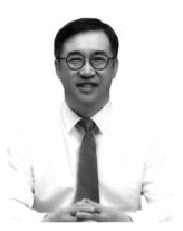

Dip. Limbert Iván de Jesús Interian Gallegos, Mexico, Cámara de Diputados
Parliamentary Webpage: http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=794
Link to Photo: http://sitl.diputados.gob.mx/LXIV_leg/fotos_lxivconfondo/501_foto_chica.jpg

Predicted Gender: male
Predicted Age: 60.0
Photo:


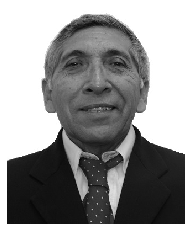

LEE JONGKOO, Republic of Korea, Kuk Hoe
Parliamentary Webpage: http://korea.assembly.go.kr/mem/mem_pro.jsp?mem_code=qC8mawJl9hA%3D
Link to Photo: http://www.assembly.go.kr/photo/9770945.jpg

Predicted Gender: male
Predicted Age: 48.0
Photo:


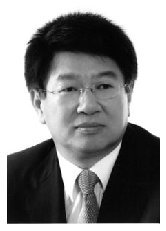

Dip. Anita Sánchez Castro, Mexico, Cámara de Diputados
Parliamentary Webpage: http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=172
Link to Photo: http://sitl.diputados.gob.mx/LXIV_leg/fotos_lxivconfondo/111_foto_chica.jpg

Predicted Gender: female
Predicted Age: 40.0
Photo:


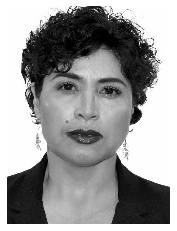

KIM SONGSIK, Republic of Korea, Kuk Hoe
Parliamentary Webpage: http://korea.assembly.go.kr/mem/mem_pro.jsp?mem_code=acw1kNGIoGY%3D
Link to Photo: http://www.assembly.go.kr/photo/9770942.jpg

Predicted Gender: male
Predicted Age: 45.0
Photo:


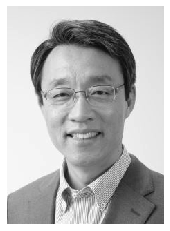

KIM YOUNGJIN, Republic of Korea, Kuk Hoe
Parliamentary Webpage: http://korea.assembly.go.kr/mem/mem_pro.jsp?mem_code=iwvk15qZ6qo%3D
Link to Photo: http://www.assembly.go.kr/photo/9770981.jpg

Predicted Gender: male
Predicted Age: 36.0
Photo:


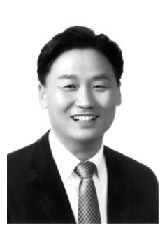

Dip. Luis Alberto Mendoza Acevedo, Mexico, Cámara de Diputados
Parliamentary Webpage: http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=30
Link to Photo: http://sitl.diputados.gob.mx/LXIV_leg/fotos_lxivconfondo/294_foto_chica.jpg

Predicted Gender: male
Predicted Age: 34.0
Photo:


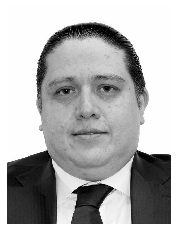

Dip. Carlos Alberto Morales Vázquez, Mexico, Cámara de Diputados
Parliamentary Webpage: http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=384
Link to Photo: http://sitl.diputados.gob.mx/LXIV_leg/fotos_lxivconfondo/434_foto_chica.jpg

Predicted Gender: male
Predicted Age: 49.0
Photo:


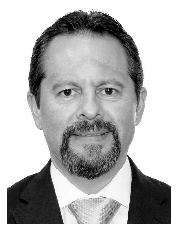

KHANG HYOSHANG, Republic of Korea, Kuk Hoe
Parliamentary Webpage: http://korea.assembly.go.kr/mem/mem_pro.jsp?mem_code=qWzmNq%2Bo3E4%3D
Link to Photo: http://www.assembly.go.kr/photo/9771054.jpg

Predicted Gender: male
Predicted Age: 48.0
Photo:


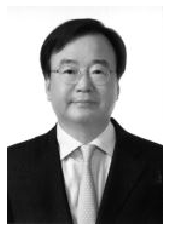

Dip. Alfredo Antonio Gordillo Moreno, Mexico, Cámara de Diputados
Parliamentary Webpage: http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=550
Link to Photo: http://sitl.diputados.gob.mx/LXIV_leg/fotos_lxivconfondo/527_foto_chica.jpg

Predicted Gender: male
Predicted Age: 44.0
Photo:


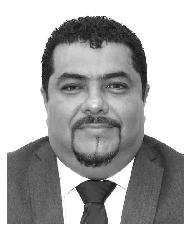

Dip. Miguel Alonso Riggs Baeza, Mexico, Cámara de Diputados
Parliamentary Webpage: http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=67
Link to Photo: http://sitl.diputados.gob.mx/LXIV_leg/fotos_lxivconfondo/287_foto_chica.jpg

Predicted Gender: male
Predicted Age: 37.0
Photo:


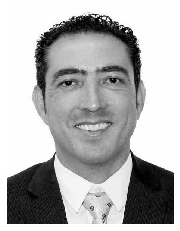

Dip. Rocío Barrera Badillo, Mexico, Cámara de Diputados
Parliamentary Webpage: http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=26
Link to Photo: http://sitl.diputados.gob.mx/LXIV_leg/fotos_lxivconfondo/073_foto_chica.jpg

Predicted Gender: female
Predicted Age: 35.0
Photo:


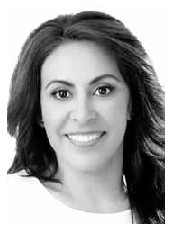

Dip. Juan Francisco Espinoza Eguia, Mexico, Cámara de Diputados
Parliamentary Webpage: http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=195
Link to Photo: http://sitl.diputados.gob.mx/LXIV_leg/fotos_lxivconfondo/242_foto_chica.jpg

Predicted Gender: male
Predicted Age: 46.0
Photo:


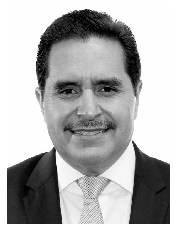

Dip. Mario Ismael Moreno Gil, Mexico, Cámara de Diputados
Parliamentary Webpage: http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=8
Link to Photo: http://sitl.diputados.gob.mx/LXIV_leg/fotos_lxivconfondo/003_foto_chica.jpg

Predicted Gender: male
Predicted Age: 65.0
Photo:


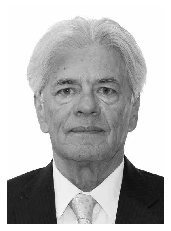

Dip. Graciela Zavaleta Sánchez, Mexico, Cámara de Diputados
Parliamentary Webpage: http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=410
Link to Photo: http://sitl.diputados.gob.mx/LXIV_leg/fotos_lxivconfondo/343_foto_chica.jpg

Predicted Gender: female
Predicted Age: 53.0
Photo:


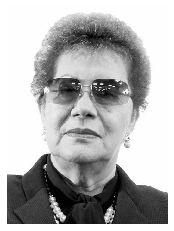

HONG MOONPYO, Republic of Korea, Kuk Hoe
Parliamentary Webpage: http://korea.assembly.go.kr/mem/mem_pro.jsp?mem_code=1J2sS0CtoU4%3D
Link to Photo: http://www.assembly.go.kr/photo/9770886.jpg

Predicted Gender: male
Predicted Age: 50.0
Photo:


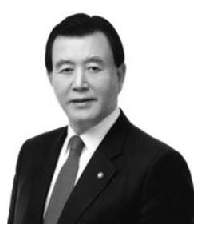

Dip. Lyndiana Elizabeth Bugarín Cortés, Mexico, Cámara de Diputados
Parliamentary Webpage: http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=298
Link to Photo: http://sitl.diputados.gob.mx/LXIV_leg/fotos_lxivconfondo/219_foto_chica.jpg

Predicted Gender: female
Predicted Age: 34.0
Photo:


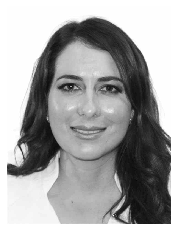

Ms.  Ramona Ramdial, MP, Trinidad and Tobago, House of Representatives
Parliamentary Webpage: http://www.ttparliament.org/members.php?mid=54&id=RRL10
Link to Photo: http://www.ttparliament.org/content_images/RRL10.jpg

Predicted Gender: female
Predicted Age: 34.0
Photo:


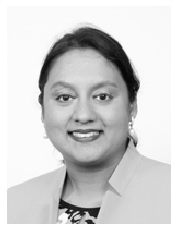

Dip. Eleuterio Arrieta Sánchez, Mexico, Cámara de Diputados
Parliamentary Webpage: http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=284
Link to Photo: http://sitl.diputados.gob.mx/LXIV_leg/fotos_lxivconfondo/006_foto_chica.jpg

Predicted Gender: male
Predicted Age: 58.0
Photo:


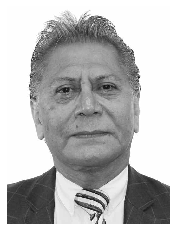

Dip. Claudia Valeria Yáñez Centeno y Cabrera, Mexico, Cámara de Diputados
Parliamentary Webpage: http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=47
Link to Photo: http://sitl.diputados.gob.mx/LXIV_leg/fotos_lxivconfondo/105_foto_chica.jpg

Predicted Gender: female
Predicted Age: 44.0
Photo:


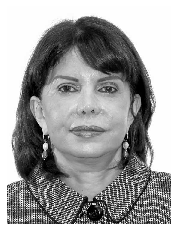

In [7]:
st.show_predictions(df_alpha, n_sample = 20)